# Baseline-population

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

import transformers
from transformers import AutoTokenizer
transformers.logging.set_verbosity_error()

import re
from tqdm import tqdm

import argparse
import wandb
from wandb.keras import WandbCallback
wandb.init(project="DACON_235900", name="Baseline-population")

parser = argparse.ArgumentParser(description='Baseline-population')
parser.add_argument('--pretrained_model', default="codebert", type=str)
parser.add_argument('--max_length', default=256, type=int)
parser.add_argument('--optimizer', default="sgd", type=str) # sgd or adam
parser.add_argument('--learning_rate', default=0.01, type=float)
parser.add_argument('--batch_size', default=32, type=int)
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

if args.pretrained_model == "bert":
    pretrained_model = "bert-base-uncased"
elif args.pretrained_model == "codebert":
    pretrained_model = "microsoft/graphcodebert-base"
    
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, do_lower_case=True)
tokenizer.truncation_side='left'

MAX_LENGTH = args.max_length
BATCH_SIZE=args.batch_size
EPOCHS=args.epochs
SEED=args.seed

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

wandb: Currently logged in as: gnoeyheat (use `wandb login --relogin` to force relogin)


## Preprocessing

In [2]:
train = pd.read_csv(f"data/train_{args.pretrained_model}.csv").dropna().sample(frac=0.01)
valid = pd.read_csv(f"data/valid_{args.pretrained_model}.csv").dropna().sample(frac=0.01)
test = pd.read_csv("data/test.csv")

train.shape, valid.shape, test.shape

((42431, 3), (2547, 3), (179700, 3))

## Modelling

In [3]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(
        self,
        sentence_pairs,
        labels=[0, 1],
        batch_size=BATCH_SIZE,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        self.tokenizer = tokenizer
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="tf",
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.RandomState(SEED).shuffle(self.indexes)

In [4]:
input_ids = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids"
)
attention_masks = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_masks"
)
token_type_ids = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), dtype=tf.int32, name="token_type_ids"
)

bert_model = transformers.TFAutoModel.from_pretrained(pretrained_model)
bert_model.trainable = False

bert_output = bert_model(
    input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
)

sequence_output = bert_output.last_hidden_state
pooled_output = bert_output.pooler_output

bi_lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=True)
)(sequence_output)

avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
                                                        
model = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_masks[0][0]',    

## Training

In [5]:
X_train = train[["code1", "code2"]]
y_train = train["similar"]

X_val = valid[["code1", "code2"]]
y_val =  valid["similar"]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((42431, 2), (2547, 2), (42431,), (2547,))

In [6]:
train_data = BertSemanticDataGenerator(
    X_train[["code1", "code2"]].values,
    y_train.values,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    X_val[["code1", "code2"]].values,
    y_val.values,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [7]:
lr = tf.keras.optimizers.schedules.CosineDecay(args.learning_rate, decay_steps=1000)
if args.optimizer == "sgd":
    optim = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
elif args.optimizer == "adam":
    optim = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(
    optimizer=optim,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

checkpoint_filepath=f"load_model/{parser.description}"

callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
]


history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    callbacks=[callback, WandbCallback()],
)

Epoch 1/100
1325/1325 [==============================] - 355s 255ms/step - loss: 0.4969 - accuracy: 0.7505 - val_loss: 0.4167 - val_accuracy: 0.8058 - _timestamp: 1654838071.0000 - _runtime: 415.0000
Epoch 2/100
1325/1325 [==============================] - 327s 247ms/step - loss: 0.4384 - accuracy: 0.7924 - val_loss: 0.4167 - val_accuracy: 0.8058 - _timestamp: 1654838400.0000 - _runtime: 744.0000
Epoch 3/100
1325/1325 [==============================] - 328s 247ms/step - loss: 0.4372 - accuracy: 0.7930 - val_loss: 0.4167 - val_accuracy: 0.8058 - _timestamp: 1654838728.0000 - _runtime: 1072.0000
Epoch 4/100
1325/1325 [==============================] - 329s 249ms/step - loss: 0.4394 - accuracy: 0.7931 - val_loss: 0.4167 - val_accuracy: 0.8058 - _timestamp: 1654839057.0000 - _runtime: 1401.0000
Epoch 5/100
1325/1325 [==============================] - 327s 247ms/step - loss: 0.4370 - accuracy: 0.7928 - val_loss: 0.4167 - val_accuracy: 0.8058 - _timestamp: 1654839384.0000 - _runtime: 1728.00

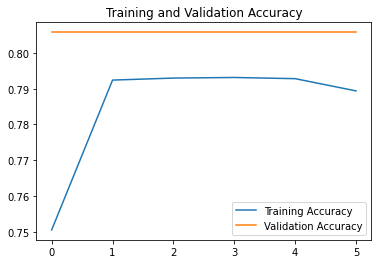

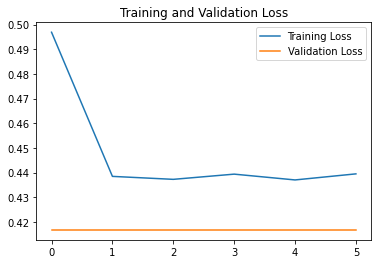

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
model.load_weights(checkpoint_filepath)

### Fine Tuning

In [10]:
bert_model.trainable = True

lr = tf.keras.optimizers.schedules.CosineDecay(args.learning_rate*0.1, decay_steps=1000)
if args.optimizer == "sgd":
    optim = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
elif args.optimizer == "adam":
    optim = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(
    optimizer=optim,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

checkpoint_filepath=f"load_model/{parser.description}"

callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
]

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    callbacks=[callback, WandbCallback()],
)

Epoch 1/100
1325/1325 [==============================] - 674s 495ms/step - loss: 0.2652 - accuracy: 0.8916 - val_loss: 0.2287 - val_accuracy: 0.9122 - _timestamp: 1654840387.0000 - _runtime: 2731.0000
Epoch 2/100
1325/1325 [==============================] - 649s 489ms/step - loss: 0.2014 - accuracy: 0.9207 - val_loss: 0.2287 - val_accuracy: 0.9118 - _timestamp: 1654841039.0000 - _runtime: 3383.0000
Epoch 3/100
1325/1325 [==============================] - 652s 492ms/step - loss: 0.2018 - accuracy: 0.9206 - val_loss: 0.2286 - val_accuracy: 0.9118 - _timestamp: 1654841689.0000 - _runtime: 4033.0000
Epoch 4/100
1325/1325 [==============================] - 657s 496ms/step - loss: 0.2002 - accuracy: 0.9208 - val_loss: 0.2286 - val_accuracy: 0.9118 - _timestamp: 1654842346.0000 - _runtime: 4690.0000
Epoch 5/100
1325/1325 [==============================] - 646s 488ms/step - loss: 0.2013 - accuracy: 0.9201 - val_loss: 0.2287 - val_accuracy: 0.9122 - _timestamp: 1654842995.0000 - _runtime: 5339.

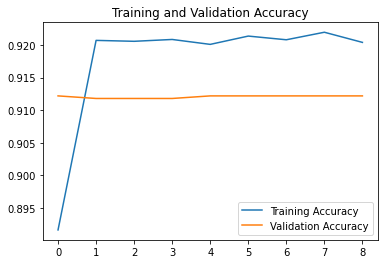

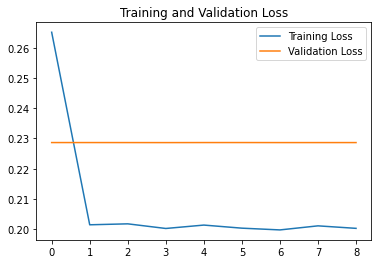

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model.load_weights(checkpoint_filepath)

## Inference

In [13]:
test_data = BertSemanticDataGenerator(
    test[["code1", "code2"]].values,
    None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    include_targets=False,
)

In [14]:
preds=[]
for i in tqdm(range((len(test)//BATCH_SIZE)+1)):
    temp = test_data[i]
    preds.append(model.predict(temp))
preds=np.vstack(preds)

preds.shape

100%|██████████████████████████████████████████████████████████████████████████████| 5616/5616 [23:12<00:00,  4.03it/s]


(179700, 1)

In [15]:
submission = pd.read_csv("data/sample_submission.csv")
submission['similar'] = np.where(preds>0.5, 1, 0)
submission.to_csv(f"{parser.description}.csv", index=False)